In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.geoencoder import LoadGeoEncoderModel
from models.forward import LoadForwardModel
from models.configs import models_configs, LoadData, POINTS_CLOUD_PADDING_VALUE
from torch.utils.data import DataLoader
from skimage import measure
from tqdm import tqdm
import time
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
configs = models_configs()

filebase = configs["ForwardModel"]["filebase"]
model_args = configs["ForwardModel"]["model_args"]
geo_encoder_model_args = configs["GeoEncoder"]["model_args"]
print(f"\n\nForwardModel Filebase: {filebase}, model_args:")
print(model_args)
print("\n\n model_args:")
print(geo_encoder_model_args)

fwd_model = LoadForwardModel(filebase, model_args, geo_encoder_model_args)



ForwardModel Filebase: /work/hdd/bdsy/qibang/repository_Wbdsy/GeoSDF2D/models/saved_weights/fwd_outc256_latentdim256_noatt_normgroups-None_dropout-0.1_nx120, model_args:
{'img_shape': (1, 120, 120), 'channel_mutipliers': [1, 2, 4, 8], 'has_attention': [False, False, True, True], 'first_conv_channels': 16, 'num_res_blocks': 1, 'norm_groups': None, 'dropout': 0.1}


 model_args:
{'out_c': 256, 'latent_d': 256, 'width': 128, 'n_point': 128, 'n_sample': 8, 'radius': 0.2, 'd_hidden': [128, 128], 'num_heads': 4, 'cross_attn_layers': 1, 'self_attn_layers': 3, 'pc_padding_val': 1000, 'd_hidden_sdfnn': [128, 128], 'latent_d_sdfnn': 256, 'in_c_sdfnn': 256, 'fps_method': 'fps'}
Total number of parameters of Geo encoder: 1132160, 1132160 of which are trainable
Total number of parameters of SDF NN: 4203517, 4203517 of which are trainable
Total number of trainable parameters of fwd model: 2251358


In [3]:
train_dataset, test_dataset, grid_coor, sdf_inv_scaler, stress_inv_scaler = LoadData()
grid_coor = grid_coor.to(device)



In [4]:


def predict(data, fwd_model, grid_coor):
    y_pred = []
    y_true = []
    fwd_model = fwd_model.to(device)
    fwd_model.eval()
    with torch.no_grad():
        if isinstance(data, DataLoader):
            for data in tqdm(data, desc="Predicting"):
                pc = data[0].to(device)
                pred = fwd_model(pc, grid_coor)
                pred = pred.cpu().detach().numpy()
                y_pred.append(pred)
                y_true.append(data[1].cpu().detach().numpy())
            y_true = np.vstack(y_true)
            y_pred = np.vstack(y_pred)
    return y_pred, y_true


def plot_geo_from_sdf(sdf_norm, pc_pad, ax):
    sdf = sdf_inv_scaler(sdf_norm.cpu().detach().numpy())
    sdf = sdf.reshape(120, 120)
    geo = measure.find_contours(
        sdf, 0, positive_orientation='high')
    nx = sdf.shape[0]-1
    id_pc = np.where(pc_pad[:, 0] != POINTS_CLOUD_PADDING_VALUE)[0]
    pc = pc_pad[id_pc]
    for c, contour in enumerate(geo):
        contour = contour*1.2/nx-0.1
        x, y = contour[:, 1], contour[:, 0]
        if c == 0:

            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="cyan", label="Outer Boundary")
        else:
            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="white", label="Hole")
    ax.plot(pc[:, 0], pc[:, 1], 'ro', markersize=1)
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")



In [5]:
time_start = time.time()
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
s_pred, s_true = predict(test_loader, fwd_model, grid_coor)
s_pred = stress_inv_scaler(s_pred)
s_true = stress_inv_scaler(s_true)
time_end = time.time()
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred):.2e} seconds")


Predicting: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

Time taken to predict one sample: 8.01e-04 seconds


Mean L2 error of stress: 0.036120492964982986, std: 0.030416501685976982
Index 0 for Best: 5175, error: 0.0022979439236223698
Index 1 for 32% percentile: 102, error: 0.019803352653980255
Index 2 for 64% percentile: 9675, error: 0.03593430295586586
Index 3 for 99% percentile: 6527, error: 0.14497245848178864


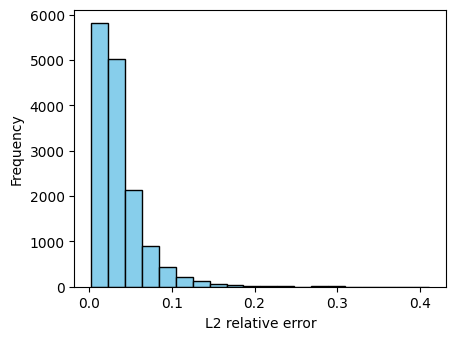

In [6]:
error_s = np.linalg.norm(s_pred-s_true, axis=1) / \
    np.linalg.norm(s_true, axis=1)
mean, std = np.mean(error_s), np.std(error_s)
sort_idx = np.argsort(error_s)
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)

_ = ax.hist(error_s[sort_idx[:-2]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")

print(f"Mean L2 error of stress: {mean}, std: {std}")


titles = ["Best", "32% percentile", "64% percentile", "99% percentile"]
min_index = sort_idx[0]
max_index = sort_idx[int(len(sort_idx)*0.99-1)]
median_index = sort_idx[int(len(sort_idx) * 0.32)]
median_index2 = sort_idx[int(len(sort_idx) * 0.64)]
indices = np.array([min_index, median_index, median_index2, max_index])
for i in range(len(indices)):
    print(
        f"Index {i} for {titles[i]}: {indices[i]}, error: {error_s[indices[i]]}")

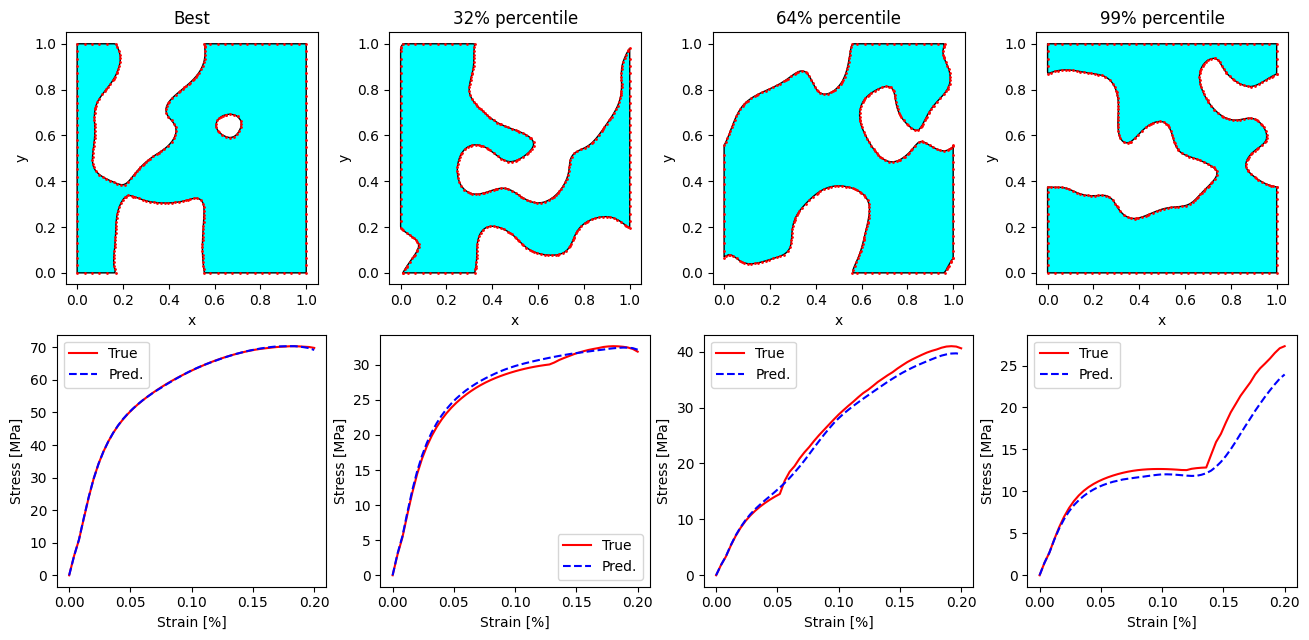

In [7]:
nr, nc = 2, 4
fig = plt.figure(figsize=(nc*4.0, nr*3.6))
strain = np.linspace(0, 0.2, 51)
for ic in range(nc):
    ir = 0
    index = indices[ic]
    s_pred_i = s_pred[index]
    s_true_i = s_true[index]
    sdf_norm = test_dataset[index][2]
    pc = test_dataset[index][0]
    ax = plt.subplot(nr, nc, ic+1)
    plot_geo_from_sdf(sdf_norm, pc, ax)
    ax.set_title(f"{titles[ic]}")
    ax = plt.subplot(nr, nc, ic+nc+1)
    ax.plot(strain, s_true_i, 'r', label="True")
    ax.plot(strain, s_pred_i, 'b--', label="Pred.")
    ax.set_xlabel("Strain [%]")
    ax.set_ylabel("Stress [MPa]")
    ax.legend()
